# Regional Tasmanian domain forced by JRA55-do reanalysis and ACCESS-OM2-01 model output

## What does this notebook do?
This notebook uses `regional-mom6` package to set up a regional ocean configuration with MOM6.

At first we suggest you ensure that the default Tasmania configuration runs OK. Afterwards, you can modify the notebook to the region of your interest.

Input Type | Source | Location on NCI
---|---|---
Surface | [JRA55-do surface forcing](https://climate.mri-jma.go.jp/pub/ocean/JRA55-do/) | `/g/data/ik11`
Ocean | [ACCESS-OM2-01](https://github.com/COSIMA/access-om2) |  `/g/data/ik11`  
Bathymetry | [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) | `/g/data/ik11`

Additionally, you'll need access to `/g/data/x77/` if you want to use the same executable using the latest FMS build (a good idea for troubleshooting).

To use your own version of the `regional_mom6` package, clone the entire [github repository](https://github.com/COSIMA/regional-mom6)
on your machine and set the `regional-mom6` path using the `os` library, as shown below:

In [1]:
import os
import xarray as xr
from pathlib import Path
from dask.distributed import Client

In [2]:
os.chdir("/home/581/lxy581/tidal_param/regional-mom6")
import regional_mom6 as rmom6
print("using regional-mom6 version" + rmom6.__version__)

using regional-mom6 vunknown


Start a dask client.

In [3]:
client = Client()
client

## What does the `regional-mom6` package do?

Setting up a regional model in MOM6 can be a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

This notebook will guide you to configure a running MOM6 regional model. There will still be a lot of fiddling to do with the `MOM_input` file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. *But*, `regional-mom6` package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the MOM6 boundary segment files.

Wanna find out more about `regional-mom6` package? Go to the [package's documentation](https://regional-mom6.readthedocs.io/en/latest/).

## What does this notebook do?

This notebook demonstrates how to set up a regional domain using the package. By the end you should have a running MOM6 experiment on the domain of your choice. To make a stable test case:

* Avoid any regions with ice
* Avoid regions near the North pole
* Although the default configuration is meant to be repeat-year forced (RYF), the calendar and encoding will need fixing to run longer than a year


Input Type | Source
---|---
Surface | JRA55-do
Ocean | ACCESS-OM2-01
Bathymetry | Gebco

## Step 0: Your personal environment variables

In [4]:
scratch = "/scratch/nm03/lxy581"
gdata = "/g/data/nm03/lxy581"
home = "/home/581/lxy581"

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

You can log in and use [this GUI](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) to find the lat/lon of your domain and copy paste below.

In [5]:
expt_name = "tassie-access-om2-forced"

latitude_extent = [-48, -38.95]
longitude_extent = [143, 150]

date_range = ["2003-01-01 00:00:00", "2003-01-05 00:00:00"]

## Place where all the input files go
input_dir = f"{scratch}/regional_mom6_configs/{expt_name}/"

## Directory where we'll be running the experiment from
run_dir = f"{home}/mom6_rundirs/{expt_name}/"

## Directory where compiles FRE tools are located (needed for construction of mask tables)
toolpath_dir = "/home/157/ahg157/repos/mom5/src/tools/"

## Directory where ocean model cut-outs go before processing
tmp_dir = f"{gdata}/{expt_name}"

## if directories don't exist, create them
for path in (run_dir, tmp_dir, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` and `"ic_unprocessed"` for initial condition. The following provides an example for cutting out the necessary forcing files from an ocean model. It's hardcoded to pull data from a Repeat-Year Forced ACCESS-OM2-01 database, but you should be able to recycle parts of the code to cut out data from a dataset of your choice

**NOTE: this is hardcoded for the year of 1990, which corresponds to output files `1077`-`1082`. If you want to modify, you'll need to choose the right path to the year of your choice, or use the [COSIMA cookbook](https://cosima-cookbook.readthedocs.io/) to locate your data files.**

In [6]:
## Cut out 3 months of forcing from 2003
print('Open dataset...')

buffer = 0.2

om2_input = xr.open_mfdataset(
    f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077/ocean/ocean_daily*.nc",
    parallel=True, compat='override', chunks='auto')[["u", "v", "salt", "temp", "eta_t"]].sel(
        yu_ocean = slice(latitude_extent[0] - buffer, latitude_extent[1] + buffer),
        yt_ocean = slice(latitude_extent[0] - buffer, latitude_extent[1] + buffer)).isel(time = slice(0, 5))

print('Initial condition...')
## Cut out initial condition and save
ic = om2_input.isel(time = 0)

## `longitude_slicer` handles seams in longitude and different grid and ensures that the output matches our 'longitude_extent'
ic = rmom6.longitude_slicer(ic, [longitude_extent[0], longitude_extent[1]], ["xu_ocean", "xt_ocean"])
ic.to_netcdf(tmp_dir + "/ic_unprocessed.nc")

print('East west bc...')
rmom6.longitude_slicer(om2_input, [longitude_extent[1]-buffer, longitude_extent[1]+buffer], ["xu_ocean", "xt_ocean"]).to_netcdf(tmp_dir + "/east_unprocessed.nc")
rmom6.longitude_slicer(om2_input, [longitude_extent[0]-buffer, longitude_extent[0]+buffer], ["xu_ocean", "xt_ocean"]).to_netcdf(tmp_dir + "/west_unprocessed.nc")

print('North south bc...')
## Cut out North and South segments
northsouth = rmom6.longitude_slicer(om2_input, [longitude_extent[0]-buffer, longitude_extent[1]+buffer], ["xu_ocean", "xt_ocean"])
northsouth.sel(
    yu_ocean = slice(latitude_extent[1] - buffer, latitude_extent[1] + buffer),
    yt_ocean = slice(latitude_extent[1] - buffer, latitude_extent[1] + buffer)
).to_netcdf(tmp_dir + "/north_unprocessed.nc")
northsouth.sel(
    yu_ocean = slice(latitude_extent[0] - buffer, latitude_extent[0] + buffer),
    yt_ocean = slice(latitude_extent[0] - buffer, latitude_extent[0] + buffer)
).to_netcdf(tmp_dir + "/south_unprocessed.nc")

Open dataset...
Initial condition...
East west bc...
North south bc...


## Step 3: Make experiment object
The `regional_mom6.experiment` contains the regional domain basics, and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the directory structures. 

In [7]:
expt = rmom6.experiment(
    longitude_extent = longitude_extent,
    latitude_extent = latitude_extent,
    date_range = date_range,
    resolution = 0.05,
    number_vertical_layers = 75,
    layer_thickness_ratio = 10,
    depth = 4500,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    toolpath_dir = toolpath_dir
)

We can now access the horizontal and vertical grid of the regional configuration via `expt.hgrid` and `expt.vgrid` respectively.

Plotting the vertical grid with `marker = '.'` lets you see the spacing. You can use `numpy.diff` to compute the vertical spacings, e.g.,
```python
import numpy as np
np.diff(expt.vgrid.zl).plot(marker = '.')
```
shows you the vertical spacing profile.

### Modular workflow!

After constructing your `expt` object, if you don't like the default `hgrid` and `vgrid` you can simply modify and then save them back into the `expt` object. However, you'll then also need to save them to disk again. For example:

```python
new_hgrid = xr.open_dataset(input_dir + "/hgrid.nc")
```
Modify `new_hgrid`, ensuring that _all metadata_ is retained to keep MOM6 happy. Then, save your changes

```python
expt.hgrid = new_hgrid

expt.hgrid.to_netcdf(input_dir + "/hgrid.nc")
```

## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [8]:
expt.setup_bathymetry(
    bathymetry_path='/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation',
    minimum_layers=1
    )

Begin regridding bathymetry...

If this process hangs it means that the chosen domain might be too big to handle this way. After ensuring access to appropriate computational resources, try calling ESMF directly from a terminal in the input directory via

mpirun ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var elevation --dst_var elevation --netcdf4 --src_regional --dst_regional

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run 'tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.
Regridding in parallel: True
Regridding finished. Now calling `tidy_bathymetry` method for some finishing touches...
Reading in regridded bathymetry to fix up metadata...done.


### Check out your domain:

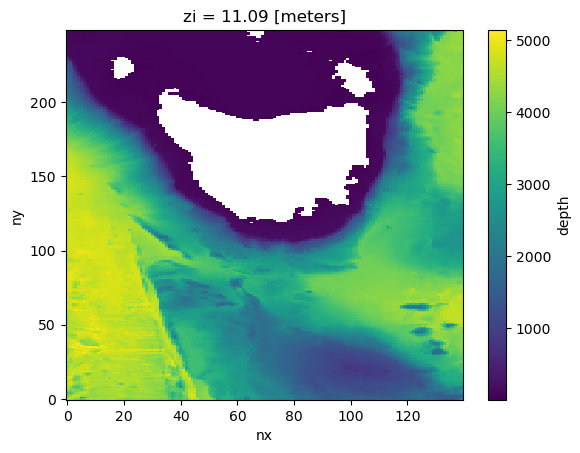

In [9]:
expt.bathymetry.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initDefine a mapping from MOM5's B grid variables and dimensions to MOM6's C grid onesial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how the horizontal dimensions are `xt_ocean`, `yt_ocean`, `xu_ocean`, `yu_ocean` in ACCESS-OM2-01 versus `xh`, `yh`, `xq`, and `yq` in MOM6. This is because ACCESS-OM2-01 is on a `B` grid, so we need to differentiate between `q` and `t` points. 

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update `MOM_input` to reflect this though so it knows how many segments to look for, and their orientations. 

Define a mapping from the MOM5 B grid variables and dimensions to the MOM6 C grid ones

In [10]:
ocean_varnames = {"time": "time",
                  "yh": "yt_ocean",
                  "xh": "xt_ocean",
                  "xq": "xu_ocean",
                  "yq": "yu_ocean",
                  "zl": "st_ocean",
                  "eta": "eta_t",
                  "u": "u",
                  "v": "v",
                  "tracers": {"salt": "salt", "temp": "temp"}
                  }

Set up the initial condition

No `xu_ocean` and `xt_ocean` in **west_unprocessed.nc** and **east_unprocessed.nc**

`xu_ocean = UNLIMITED ; // (0 currently)`

In [11]:
expt.initial_condition(
    tmp_dir / "ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="B"
    )

# Set up the four boundary conditions.
expt.rectangular_boundaries(
    tmp_dir,
    ocean_varnames,
    boundaries = ["south", "north", "west", "east"],
    arakawa_grid = "B"
    )

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... Done.
Finished setting up initial condition.
[########################################] | 100% Completed | 102.30 ms
Done.
[########################################] | 100% Completed | 101.99 ms
Done.
[########################################] | 100% Completed | 101.97 ms
Done.
[########################################] | 100% Completed | 101.81 ms
Done.


## Step 6: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're saying that we want a 10 by 10 grid of 100 processors. 

In [12]:
expt.FRE_tools(layout = (10, 10)) ## Here the tuple defines the processor layout

Running GFDL's FRE Tools. The following information is all printed by the FRE tools themselves
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
OUTPUT FROM MAKE SOLO MOSAIC:

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)
cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file bathymetry.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
OUTPUT FROM QUICK MOSAIC:

CompletedProcess(args='/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog bathymetry.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>N

cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


## Step 7: Modify the default input directory to make a (hopefully) runnable configuration out of the box

This step copies the default directory, and modifies the `MOM_layout` files to match your experiment by inserting the right number of x,y points and cpu layout. If you use Payu to run MOM6, set the `using_payu` flag to `True` and an example `config.yaml` file will be copied to your run directory. This still needs to be modified manually to work with your projects, executable etc.



In [13]:
expt.setup_run_directory(surface_forcing = "jra", using_payu = True)

Number of CPUs required:  98


## Step 8: Run your model!

To do this, navigate to your run directory in terminal. If you're working on NCI, you can run your model via:

```
module load conda/analysis3
payu setup -f
payu run -f
```

By default `input.nml` is set to only run for 5 days as a test. If this is successful, you can modify this file to then run for longer.

## Step 9 and beyond: Fiddling, troubleshooting and fine tuning

Hopefully your model is running. If not, the first thing you should do is reduce the timestep. You can do this by adding `#override DT=XXXX` to your `MOM_override` file. 

If there's strange behaviour on your boundaries, you could play around with the `nudging timescale` (an example is already included in the `MOM_override` file). Sometimes, if your boundary has a lot going on (like all of the eddies spinning off the western boundary currents or off the Antarctic Circumpolar current), it can be hard to avoid these edge effects. This is because the chaotic, submesoscale structures developed within the regional domain won't match those at the boundary.

Another thing that can go wrong is little bays creating non-advective cells at your boundaries. Keep an eye out for tiny bays where one side is taken up by a boundary segment. You can either fill them in manually, or move your boundary slightly to avoid them